In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [3]:
import geopandas as gpd

In [38]:
from private.key import access_key, secret_access_key

### Files

In [5]:
cities = pd.read_csv(f"s3://cleandatagrupo07/cities.csv", storage_options={
                "key": access_key,
                "secret": secret_access_key
                })
homes_sold = pd.read_csv(f"s3://cleandatagrupo07/homes_sold_&_total_2022.csv", storage_options={
                "key": access_key,
                "secret": secret_access_key})
weather_events = pd.read_csv(f"s3://cleandatagrupo07/weather_events.csv",
    storage_options={
        "key": access_key,
        "secret": secret_access_key
    },
)
population = pd.read_csv(f"s3://cleandatagrupo07/population.csv", storage_options={
                "key": access_key,
                "secret": secret_access_key})
rental= pd.read_csv(f"s3://cleandatagrupo07/rental_prices.csv", storage_options={
                "key": access_key,
                "secret": secret_access_key})
states_id= pd.read_csv(f"s3://cleandatagrupo07/states_id.csv", storage_options={
                "key": access_key,
                "secret": secret_access_key})
city = pd.read_csv(f"s3://cleandatagrupo07/city_lat_lon.csv",
    storage_options={
        "key": access_key,
        "secret": secret_access_key
    },
    )
crime_rate = pd.read_csv(f"s3://cleandatagrupo07/crime_rate.csv",
    storage_options={
        "key": access_key,
        "secret": secret_access_key
    },
)    
listing_prices=pd.read_csv(f"s3://cleandatagrupo07/listing_price_no_null.csv",
    storage_options={
        "key": access_key,
        "secret": secret_access_key
    },
)

### Listing prices

In [44]:
listing_prices.head(2)

,Unique_City_ID,Date,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,MedianListingPrice_5BedroomOrMore,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence
0,abbevilleabbevillesc,2011-01-31,175975.777778,146616.809524,191735.468121,288451.720041,346760.873239,212560.766105,175503.075342,163125.06981,217301.993476
1,abbevillehenryal,2011-01-31,203358.333333,241787.500000,159500.000000,280921.713656,376915.444444,186006.167323,353600.000000,163125.06981,194250.000000


In [6]:
listing_prices = pd.merge(listing_prices,city,how='inner',on=['Unique_City_ID'])

In [19]:
listing_prices['Date'] = pd.to_datetime(listing_prices['Date'])

In [20]:
listing_prices['Year'] = listing_prices['Date'].dt.year

### Weather events

In [35]:
weather_events

,Unique_City_ID,Year,Month,Type,Precipitation(in),Hours
0,fairhopebaldwinal,2016,1,Cold,0.00,2.333333
1,fairhopebaldwinal,2016,1,Fog,0.00,19.000000
2,fairhopebaldwinal,2016,1,Rain,5.13,45.666667
3,fairhopebaldwinal,2016,2,Fog,0.00,3.000000
4,fairhopebaldwinal,2016,2,Precipitation,0.36,0.333333
...,...,...,...,...,...,...
308799,winchesterfranklintn,2021,10,Precipitation,1.19,0.666667
308800,winchesterfranklintn,2021,11,Fog,0.00,41.000000
308801,winchesterfranklintn,2021,11,Precipitation,0.35,0.333333
308802,winchesterfranklintn,2021,12,Fog,0.00,34.666667


### Weather type

The categorical column type is not numerical so it should be encoded, otherwise the machine learning model won't work.

In [59]:
weather_events.Type.unique()

array(['Cold', 'Fog', 'Rain', 'Precipitation', 'Snow', 'Storm', 'Hail'],
      dtype=object)

In [7]:
df_dummies = pd.get_dummies(weather_events.Type)

In [8]:
df_dummies.drop(['Precipitation'],axis=1,inplace=True)

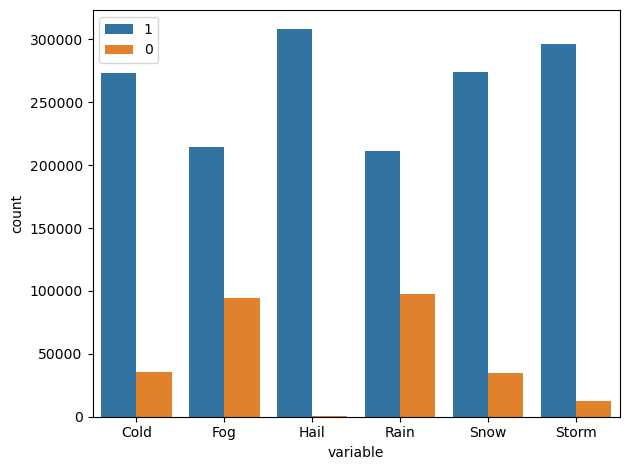

In [261]:
dfm = df_dummies.melt()
ax = sns.countplot(data=dfm, x='variable', hue='value')
ax.legend(labels=['1','0'])
plt.tight_layout()
plt.show()

In [9]:
weather_events = pd.concat([weather_events,df_dummies],axis=1)

In [10]:
weather_events.head()

,Unique_City_ID,Year,Month,Type,Precipitation(in),Hours,Cold,Fog,Hail,Rain,Snow,Storm
0,fairhopebaldwinal,2016,1,Cold,0.00,2.333333,1,0,0,0,0,0
1,fairhopebaldwinal,2016,1,Fog,0.00,19.000000,0,1,0,0,0,0
2,fairhopebaldwinal,2016,1,Rain,5.13,45.666667,0,0,0,1,0,0
3,fairhopebaldwinal,2016,2,Fog,0.00,3.000000,0,1,0,0,0,0
4,fairhopebaldwinal,2016,2,Precipitation,0.36,0.333333,0,0,0,0,0,0


We change the 1s and 0s for the percent of time that the event occured in a given month

A month has 730 hours

In [11]:
weather_events['percentage'] = (weather_events.Hours/730)*100

In [12]:
weather_types = ['Cold', 'Fog', 'Rain', 'Snow', 'Storm', 'Hail']

In [13]:
for i in weather_types:
    weather_events[f'{i}'] = weather_events[f'{i}']*weather_events.percentage

In [14]:
weather_events.drop(['Hours','Type','percentage'],axis=1,inplace=True)

In [15]:
weather_events.head()

,Unique_City_ID,Year,Month,Precipitation(in),Cold,Fog,Hail,Rain,Snow,Storm
0,fairhopebaldwinal,2016,1,0.00,0.319635,0.000000,0.0,0.000000,0.0,0.0
1,fairhopebaldwinal,2016,1,0.00,0.000000,2.602740,0.0,0.000000,0.0,0.0
2,fairhopebaldwinal,2016,1,5.13,0.000000,0.000000,0.0,6.255708,0.0,0.0
3,fairhopebaldwinal,2016,2,0.00,0.000000,0.410959,0.0,0.000000,0.0,0.0
4,fairhopebaldwinal,2016,2,0.36,0.000000,0.000000,0.0,0.000000,0.0,0.0


### Let's see the correlation with the listing prices

In [21]:
listing_prices['Month'] = listing_prices.Date.dt.month

In [22]:
price_weather = pd.merge(weather_events,listing_prices,how='inner',on=['Unique_City_ID','Year'])


In [23]:
price_weather.head()

,Unique_City_ID,Year,Month_x,Precipitation(in),Cold,Fog,Hail,Rain,Snow,Storm,...,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,City,County,State,Latitude,Longitude,Month_y
0,fairhopebaldwinal,2016,1,0.0,0.319635,0.0,0.0,0.0,0.0,0.0,...,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,1
1,fairhopebaldwinal,2016,1,0.0,0.319635,0.0,0.0,0.0,0.0,0.0,...,334783.0,242430.555556,284703.200411,329500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,2
2,fairhopebaldwinal,2016,1,0.0,0.319635,0.0,0.0,0.0,0.0,0.0,...,350000.0,242430.555556,284703.200411,339250.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3
3,fairhopebaldwinal,2016,1,0.0,0.319635,0.0,0.0,0.0,0.0,0.0,...,333820.0,242430.555556,284703.200411,329250.0,Fairhope,Baldwin,AL,30.52297,-87.90333,4
4,fairhopebaldwinal,2016,1,0.0,0.319635,0.0,0.0,0.0,0.0,0.0,...,334900.0,242430.555556,284703.200411,329000.0,Fairhope,Baldwin,AL,30.52297,-87.90333,5


In [272]:
corr = price_weather.corr()
corr.style.background_gradient(cmap='coolwarm')

,Year,Month,Precipitation(in),Cold,Fog,Hail,Rain,Snow,Storm,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,MedianListingPrice_5BedroomOrMore,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,Latitude,Longitude
Year,1.000000,-0.009822,-0.007689,-0.000784,0.021563,0.010103,0.020171,0.001482,0.001650,0.077378,0.049572,0.050042,0.031848,0.006304,0.047780,0.055390,0.045449,0.025008,0.014539,-0.012679
Month,-0.009822,1.000000,0.001036,0.009048,0.025878,-0.016895,-0.013084,-0.047628,-0.000134,-0.009103,0.009473,0.019507,0.001061,-0.002135,0.020229,0.002133,-0.006649,0.006765,0.005904,-0.005429
Precipitation(in),-0.007689,0.001036,1.000000,-0.018394,-0.046643,-0.005893,0.227599,-0.012072,-0.006968,-0.021063,-0.011304,-0.006199,-0.011013,-0.014472,-0.009105,-0.016945,-0.018259,-0.008019,-0.038069,0.034090
Cold,-0.000784,0.009048,-0.018394,1.000000,-0.039916,-0.005043,-0.060023,-0.024174,-0.005963,0.002694,0.022583,0.019981,0.004773,-0.005096,0.012126,0.020654,0.005710,0.005136,-0.017410,-0.006772
Fog,0.021563,0.025878,-0.046643,-0.039916,1.000000,-0.012788,-0.152207,-0.061301,-0.015121,0.119536,0.078787,0.060464,0.032643,0.009385,0.070650,0.073826,0.127728,0.032631,-0.003053,-0.096609
Hail,0.010103,-0.016895,-0.005893,-0.005043,-0.012788,1.000000,-0.019230,-0.007745,-0.001910,0.002192,-0.004510,-0.005645,-0.006222,0.008471,-0.005792,-0.000536,-0.012089,-0.004805,0.021555,0.019087
Rain,0.020171,-0.013084,0.227599,-0.060023,-0.152207,-0.019230,1.000000,-0.092181,-0.022738,0.004792,-0.000944,0.007551,-0.007692,-0.016010,0.000151,-0.015419,0.009410,-0.004932,0.015720,0.022904
Snow,0.001482,-0.047628,-0.012072,-0.024174,-0.061301,-0.007745,-0.092181,1.000000,-0.009158,-0.005250,-0.029086,-0.023449,0.008586,0.045366,-0.023955,0.018386,-0.064150,0.002602,0.155167,0.008867
Storm,0.001650,-0.000134,-0.006968,-0.005963,-0.015121,-0.001910,-0.022738,-0.009158,1.000000,0.000798,0.023692,0.025104,0.026961,0.040854,0.021822,0.022938,-0.012941,0.012933,0.007982,-0.026393
MedianListingPrice_1Bedroom,0.077378,-0.009103,-0.021063,0.002694,0.119536,0.002192,0.004792,-0.005250,0.000798,1.000000,0.453132,0.380042,0.247331,0.122785,0.403429,0.535724,0.597083,0.227999,0.123100,-0.321002


We see that the median list prices has some correlation with the latitude, the longitude, the snow and the fog.

We keep the relevant features.

In [24]:
price_weather.drop(['Precipitation(in)','Cold','Hail','Rain','Storm'],axis=1,inplace=True)

### Population

In [25]:
population.head()

,Unique_City_ID,Year,PopEstimate
0,oak_grovechristianky,2010,7515
1,mcminnvilleyamhillor,2010,32213
2,oshkoshwinnebagowi,2010,66323
3,garrettellistx,2010,810
4,mayesvillesumtersc,2010,729


### Let's see the correlation with the listing prices

In [58]:
population.head(2)

,Unique_City_ID,Year,PopEstimate
0,oak_grovechristianky,2010,7515
1,mcminnvilleyamhillor,2010,32213


In [26]:
price_population = pd.merge(listing_prices,population,how='inner',on=['Unique_City_ID','Year'])

In [276]:
corr = price_population.corr()
corr.style.background_gradient(cmap='coolwarm')

,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,MedianListingPrice_5BedroomOrMore,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,Latitude,Longitude,Year,Month,PopEstimate
MedianListingPrice_1Bedroom,1.000000,0.460411,0.372650,0.295313,0.109999,0.286759,0.554951,0.534386,0.271937,0.176613,-0.272039,0.096455,0.000824,0.053409
MedianListingPrice_2Bedroom,0.460411,1.000000,0.750098,0.644476,0.412534,0.570166,0.754038,0.585102,0.563268,-0.089720,-0.262978,0.213656,0.011786,0.072471
MedianListingPrice_3Bedroom,0.372650,0.750098,1.000000,0.669547,0.347763,0.665531,0.592016,0.485814,0.675438,-0.059505,-0.249235,0.179726,0.017582,0.008837
MedianListingPrice_4Bedroom,0.295313,0.644476,0.669547,1.000000,0.468856,0.585308,0.546689,0.375378,0.687869,-0.031904,-0.155224,0.181234,0.009737,0.006393
MedianListingPrice_5BedroomOrMore,0.109999,0.412534,0.347763,0.468856,1.000000,0.370380,0.374673,0.189271,0.390053,0.067249,0.035091,0.129139,0.004302,0.044979
MedianListingPrice_AllHomes,0.286759,0.570166,0.665531,0.585308,0.370380,1.000000,0.502735,0.369228,0.895723,-0.041311,-0.179077,0.153273,0.020277,0.028472
MedianListingPrice_CondoCoop,0.554951,0.754038,0.592016,0.546689,0.374673,0.502735,1.000000,0.582892,0.485769,-0.063953,-0.244509,0.251892,0.007700,0.076464
MedianListingPrice_DuplexTriplex,0.534386,0.585102,0.485814,0.375378,0.189271,0.369228,0.582892,1.000000,0.334682,-0.116955,-0.423743,0.377755,0.003512,0.083478
MedianListingPrice_SingleFamilyResidence,0.271937,0.563268,0.675438,0.687869,0.390053,0.895723,0.485769,0.334682,1.000000,-0.050921,-0.153630,0.140370,0.016263,0.015955
Latitude,0.176613,-0.089720,-0.059505,-0.031904,0.067249,-0.041311,-0.063953,-0.116955,-0.050921,1.000000,-0.090555,-0.044785,-0.003438,-0.032554


We see that there's not a significant correlation between the population and the median list prices.

In [27]:
price_population=price_population.drop(['PopEstimate'],axis=1)

Union

In [28]:
price = pd.merge(price_weather,price_population,how='inner',on=['Unique_City_ID'])

### Crime Rate

In [77]:
crime_rate.head()

,State,Year,Population,CrimePropertyRate,CrimeViolentRate
0,AL,2011,4803689,3605.4,419.8
1,AL,2012,4822023,3502.2,449.9
2,AL,2013,4833722,3351.3,430.8
3,AL,2014,4849377,3177.6,427.4
4,AL,2015,4858979,2978.9,472.4


In [29]:
crime_rate['CrimeRate'] = crime_rate.CrimePropertyRate + crime_rate.CrimeViolentRate

In [30]:
crime_rate.drop(['CrimePropertyRate','CrimeViolentRate','Population'],axis=1,inplace=True)

In [31]:
crime_rate.head()

,State,Year,CrimeRate
0,AL,2011,4025.2
1,AL,2012,3952.1
2,AL,2013,3782.1
3,AL,2014,3605.0
4,AL,2015,3451.3


### Let's see the correlation with the listing prices

In [32]:
crime_rate.head()

,State,Year,CrimeRate
0,AL,2011,4025.2
1,AL,2012,3952.1
2,AL,2013,3782.1
3,AL,2014,3605.0
4,AL,2015,3451.3


In [33]:
price_crime = pd.merge(listing_prices,crime_rate,how='inner',on=['Year'])


In [287]:
corr = price_crime.corr()
corr.style.background_gradient(cmap='coolwarm')

,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,MedianListingPrice_5BedroomOrMore,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,Latitude,Longitude,Year,Month,CrimeRate
MedianListingPrice_1Bedroom,1.000000,0.439641,0.340688,0.296946,0.058230,0.232462,0.517461,0.477911,0.220016,0.135771,-0.255163,0.090433,0.000891,-0.172600
MedianListingPrice_2Bedroom,0.439641,1.000000,0.721440,0.566002,0.364632,0.471893,0.671866,0.580190,0.474100,-0.151730,-0.280901,0.196477,0.009639,-0.079933
MedianListingPrice_3Bedroom,0.340688,0.721440,1.000000,0.574904,0.269816,0.544973,0.499844,0.435155,0.549924,-0.110332,-0.211177,0.164192,0.013637,-0.061404
MedianListingPrice_4Bedroom,0.296946,0.566002,0.574904,1.000000,0.479558,0.574194,0.476171,0.363847,0.648491,-0.055218,-0.145671,0.170176,0.007614,-0.151705
MedianListingPrice_5BedroomOrMore,0.058230,0.364632,0.269816,0.479558,1.000000,0.396614,0.324516,0.204426,0.418969,0.061060,0.035107,0.132461,0.003694,-0.300459
MedianListingPrice_AllHomes,0.232462,0.471893,0.544973,0.574194,0.396614,1.000000,0.446659,0.296121,0.879575,-0.035960,-0.098311,0.131239,0.017063,-0.133907
MedianListingPrice_CondoCoop,0.517461,0.671866,0.499844,0.476171,0.324516,0.446659,1.000000,0.514195,0.405684,-0.086589,-0.199302,0.242602,0.006830,-0.179033
MedianListingPrice_DuplexTriplex,0.477911,0.580190,0.435155,0.363847,0.204426,0.296121,0.514195,1.000000,0.274644,-0.140214,-0.424427,0.347181,0.003176,0.054800
MedianListingPrice_SingleFamilyResidence,0.220016,0.474100,0.549924,0.648491,0.418969,0.879575,0.405684,0.274644,1.000000,-0.046508,-0.093658,0.124047,0.014080,-0.125115
Latitude,0.135771,-0.151730,-0.110332,-0.055218,0.061060,-0.035960,-0.086589,-0.140214,-0.046508,1.000000,0.031223,-0.036082,-0.003409,-0.441165


We see that the median list prices has some correlation with the crime rate.

In [34]:
price = pd.merge(price,price_crime,how='inner',on=['Unique_City_ID'])

MemoryError: Unable to allocate 687. GiB for an array with shape (92187417348,) and data type int64

### homes_sold_&_total_2022

In [171]:
homes_sold.head()

,Unique_City_ID,PeriodBegin,PeriodEnd,HomesSold,HomesSold_mom,HomesSold_yoy,Inventory,Inventory_mom,Inventory_yoy
0,neptune_citymonmouthnj,2022-07-01,2022-07-31,23.0,-0.178571,0.352941,58.0,-0.079365,0.054545
1,neptune_citymonmouthnj,2022-05-01,2022-05-31,23.0,0.000000,-0.148148,64.0,0.103448,0.560976
2,neptune_citymonmouthnj,2022-09-01,2022-09-30,2.0,-0.333333,-0.500000,6.0,1.000000,0.000000
3,neptune_citymonmouthnj,2022-03-01,2022-03-31,28.0,0.333333,0.120000,60.0,0.000000,0.428571
4,neptune_citymonmouthnj,2022-07-01,2022-07-31,5.0,0.000000,0.250000,3.0,-0.571429,-0.500000


Dataframes union

In [35]:
listing_homes=listing_prices.merge(homes_sold, how='inner', on=['Unique_City_ID'])

C:\Users\fotot\AppData\Local\Temp\ipykernel_616\1135577880.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =listing_homes.corr()


<AxesSubplot: >

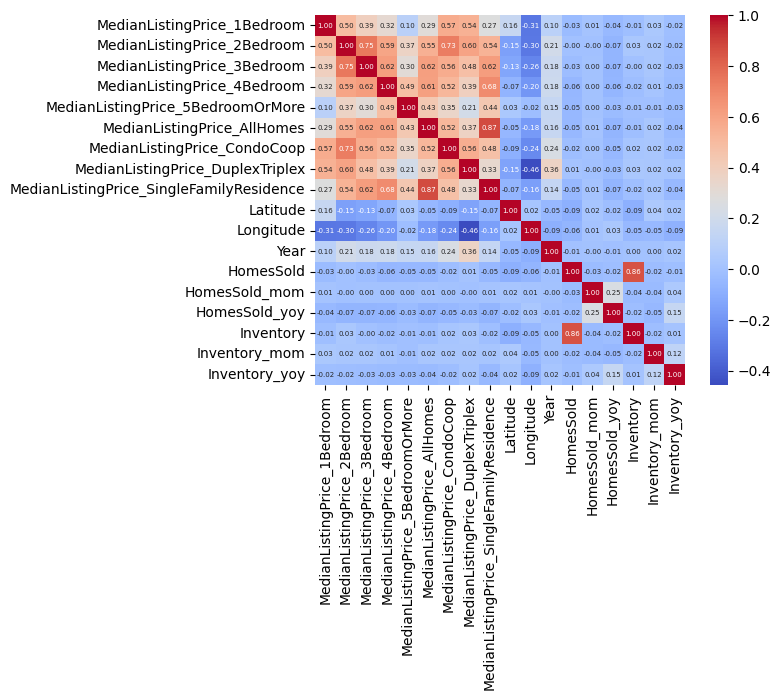

In [51]:
corr =listing_homes.corr()
sns.heatmap( corr, cbar = True,annot=True, square = True,  fmt= '.2f',annot_kws={'size':5},
           xticklabels=corr.columns,
           yticklabels=corr.columns,
           cmap= 'coolwarm')

We discard the columns that are not important for the relation

In [36]:
listing_homes=listing_homes.drop(['PeriodBegin','PeriodEnd','HomesSold_mom','HomesSold_yoy','Inventory_mom','Inventory_yoy'], axis=1)

### Union all the dataframes

In [ ]:
price=price,pd.merge(listing_homes, how='inner',on=['Unique_City_ID'])

### Final correlation

In [ ]:
corr =price.corr()
sns.heatmap( corr, cbar = True,annot=True, square = True,  fmt= '.2f',annot_kws={'size':5},
           xticklabels=corr.columns,
           yticklabels=corr.columns,
           cmap= 'coolwarm')

In [ ]:
scatter_matrix(rental,figsize=(15,10))

### MAP

In [34]:
city.head()

,Unique_City_ID,City,County,State,Latitude,Longitude
0,oak_grovechristianky,Oak Grove,Christian,KY,36.66505,-87.44279
1,jarvisburgcurritucknc,Jarvisburg,Currituck,NC,36.20294,-75.86658
2,mcminnvilleyamhillor,McMinnville,Yamhill,OR,45.21012,-123.19872
3,union_townshiperiepa,Union Township,Erie,PA,41.89402,-79.82283
4,oshkoshwinnebagowi,Oshkosh,Winnebago,WI,44.02471,-88.54261


In [35]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

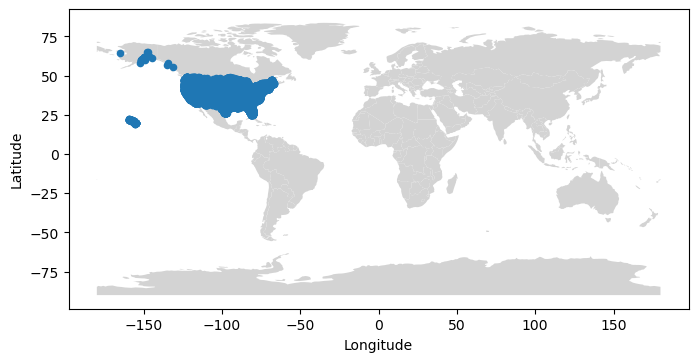

In [36]:
fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey",ax=ax)

city.plot(x="Longitude", y="Latitude", kind="scatter",ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Heat Map

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

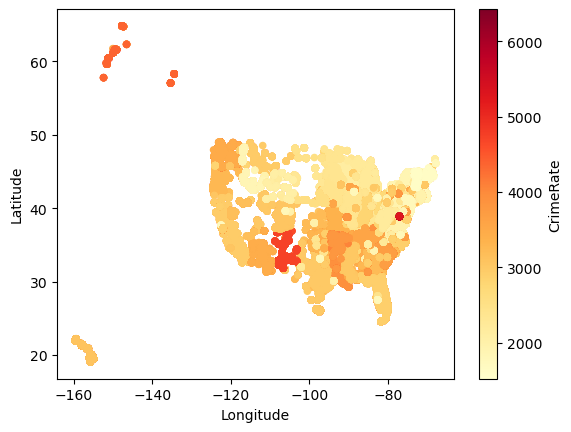

In [288]:
price_crime.plot(x="Longitude", y="Latitude", kind="scatter", c="CrimeRate",colormap="YlOrRd")

## Join tables

In [300]:
price_weather.head()

,Unique_City_ID,Year,Month,Fog,Snow,Date,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,MedianListingPrice_5BedroomOrMore,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,City,County,State,Latitude,Longitude
0,fairhopebaldwinal,2016,1,0.000000,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,443288.75,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333
1,fairhopebaldwinal,2016,1,2.602740,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,443288.75,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333
2,fairhopebaldwinal,2016,1,0.000000,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,443288.75,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333
3,fairhopebaldwinal,2016,2,0.410959,0.0,2016-02-29,262220.833333,340200.0,249900.0,369900.0,443288.75,334783.0,242430.555556,284703.200411,329500.0,Fairhope,Baldwin,AL,30.52297,-87.90333
4,fairhopebaldwinal,2016,2,0.000000,0.0,2016-02-29,262220.833333,340200.0,249900.0,369900.0,443288.75,334783.0,242430.555556,284703.200411,329500.0,Fairhope,Baldwin,AL,30.52297,-87.90333


In [301]:
crime_rate.head()

,State,Year,CrimeRate
0,AL,2011,4025.2
1,AL,2012,3952.1
2,AL,2013,3782.1
3,AL,2014,3605.0
4,AL,2015,3451.3


In [302]:
price_weather_crime = pd.merge(price_weather,crime_rate,how='inner',on=['State','Year'])


In [303]:
price_weather_crime.head()

,Unique_City_ID,Year,Month,Fog,Snow,Date,MedianListingPrice_1Bedroom,MedianListingPrice_2Bedroom,MedianListingPrice_3Bedroom,MedianListingPrice_4Bedroom,...,MedianListingPrice_AllHomes,MedianListingPrice_CondoCoop,MedianListingPrice_DuplexTriplex,MedianListingPrice_SingleFamilyResidence,City,County,State,Latitude,Longitude,CrimeRate
0,fairhopebaldwinal,2016,1,0.000000,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,...,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3480.1
1,fairhopebaldwinal,2016,1,2.602740,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,...,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3480.1
2,fairhopebaldwinal,2016,1,0.000000,0.0,2016-01-31,262220.833333,340200.0,234950.0,331300.0,...,299900.0,242430.555556,284703.200411,293500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3480.1
3,fairhopebaldwinal,2016,2,0.410959,0.0,2016-02-29,262220.833333,340200.0,249900.0,369900.0,...,334783.0,242430.555556,284703.200411,329500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3480.1
4,fairhopebaldwinal,2016,2,0.000000,0.0,2016-02-29,262220.833333,340200.0,249900.0,369900.0,...,334783.0,242430.555556,284703.200411,329500.0,Fairhope,Baldwin,AL,30.52297,-87.90333,3480.1


In [304]:
price_weather_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49452 entries, 0 to 49451
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Unique_City_ID                            49452 non-null  object        
 1   Year                                      49452 non-null  int64         
 2   Month                                     49452 non-null  int64         
 3   Fog                                       49452 non-null  float64       
 4   Snow                                      49452 non-null  float64       
 5   Date                                      49452 non-null  datetime64[ns]
 6   MedianListingPrice_1Bedroom               49452 non-null  float64       
 7   MedianListingPrice_2Bedroom               49452 non-null  float64       
 8   MedianListingPrice_3Bedroom               49452 non-null  float64       
 9   MedianListingPrice_4Bedroom 